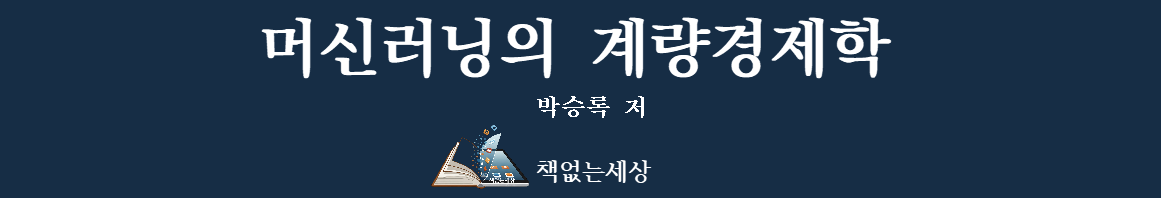

# Part 10: 딥러닝의 계량경제학

## Chapter 5. 순환 신경망(RNN)

In [1]:
# 작업공간(working directory) 지정
import os  
os.chdir("E:/JupyterWDirectory/MyStock")

# 현재 작업공간(working directory) 확인
os.getcwd() 

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한국의 GDP증가율 예측을 위한 LSTM 모형 구축
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Bidirectional, TimeDistributed, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.callbacks import EarlyStopping

# 한글폰트
import matplotlib as mpl
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

# 필자가 만든 TS_Generator 불러오기 
import sys
sys.path.append('Functions')
from TS_Generator import create_sequence_data, split_train_test, scale_data, inverse_transform_predictions


In [4]:
# 랜덤시드 reproducibility
tf.random.set_seed(12345)

# 데이터세트 불러오기(1999Q1-2023Q4)
# 한국의 거시통계(소비, 투자, 정부지출, 수출, 수입, GDP, 소비자물가, M2, 이자율, 실업률
# (time	con	inv	gov	ex	im	gdp	cpi	m2	r	un)
dataframe = pd.read_csv('Data/Korea_macro.csv', usecols=range(1, 11))

dataframe['rgdp'] = dataframe['gdp'].pct_change(4) * 100
dataframe.dropna(inplace=True)
display(dataframe)

,con,inv,gov,ex,im,gdp,cpi,m2,r,un,rgdp
4,159203,66238,30448,49224,57659,210586,62.7,684735,9.1,5.5,12.692985
5,152124,79046,27379,54719,57013,225288,62.6,683705,8.9,4.2,9.146932
6,154595,81193,28034,56508,58466,230172,63.4,697736,7.9,4.0,9.090392
7,161808,79293,29874,58507,58667,237505,63.9,707699,7.3,4.0,5.926874
8,164122,65215,31655,53464,56794,221365,65.0,720213,5.8,5.2,5.118574
...,...,...,...,...,...,...,...,...,...,...,...
95,325942,159480,89949,222599,194752,513770,109.2,3758236,3.9,2.6,1.396504
96,328884,132943,94701,212895,198370,472156,110.3,3776930,3.5,3.2,0.898598
97,318658,146190,89061,217836,185450,497346,111.0,3808194,3.4,2.7,0.889113
98,316042,148498,82450,229953,192882,500997,112.1,3839469,3.7,2.3,1.384586


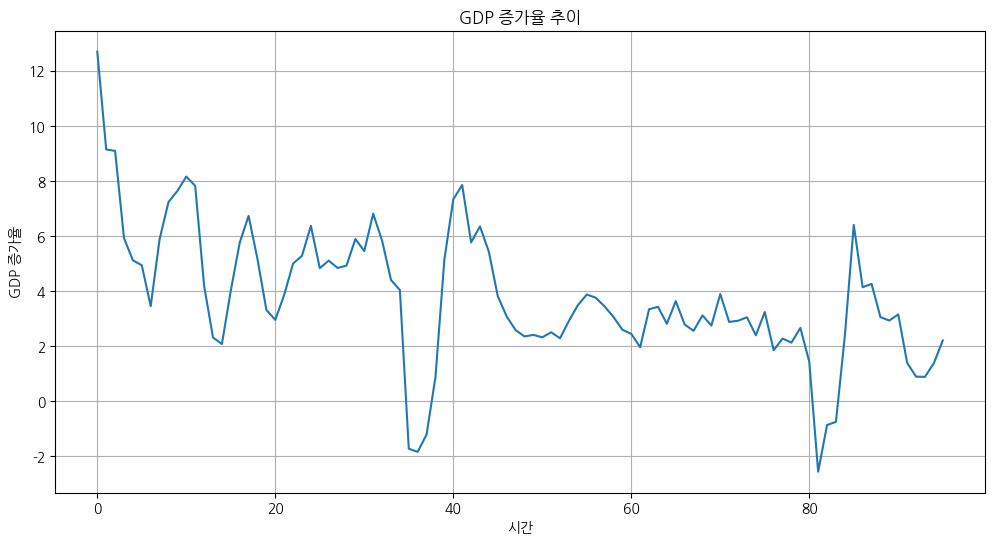

In [5]:
# GDP 증가율
Gr_gdp = dataframe['rgdp'].values

# GDP 증가율 그래프
plt.figure(figsize=(12, 6))
plt.plot(Gr_gdp)
plt.title('GDP 증가율 추이')
plt.ylabel('GDP 증가율')
plt.xlabel('시간')
plt.grid(True)
plt.show()

In [6]:
dataset = dataframe.values
dataset = dataset.astype('float32')
display(dataset[:5, :])

array([[1.5920300e+05, 6.6238000e+04, 3.0448000e+04, 4.9224000e+04,
        5.7659000e+04, 2.1058600e+05, 6.2700001e+01, 6.8473500e+05,
        9.1000004e+00, 5.5000000e+00, 1.2692985e+01],
       [1.5212400e+05, 7.9046000e+04, 2.7379000e+04, 5.4719000e+04,
        5.7013000e+04, 2.2528800e+05, 6.2599998e+01, 6.8370500e+05,
        8.8999996e+00, 4.1999998e+00, 9.1469326e+00],
       [1.5459500e+05, 8.1193000e+04, 2.8034000e+04, 5.6508000e+04,
        5.8466000e+04, 2.3017200e+05, 6.3400002e+01, 6.9773600e+05,
        7.9000001e+00, 4.0000000e+00, 9.0903921e+00],
       [1.6180800e+05, 7.9293000e+04, 2.9874000e+04, 5.8507000e+04,
        5.8667000e+04, 2.3750500e+05, 6.3900002e+01, 7.0769900e+05,
        7.3000002e+00, 4.0000000e+00, 5.9268742e+00],
       [1.6412200e+05, 6.5215000e+04, 3.1655000e+04, 5.3464000e+04,
        5.6794000e+04, 2.2136500e+05, 6.5000000e+01, 7.2021300e+05,
        5.8000002e+00, 5.1999998e+00, 5.1185737e+00]], dtype=float32)

### 가. LSTM을 위한 시계열 자료의 재구성
##### - 시계열 자료가 입력 데이터의 3차원 구조인 [샘플 수, 시간 단계, 특성 수]와 같은 배열의 형태로 표현되어야함.
##### - 이 작업이 매우 혼란스러워서 쉽게 시계열 자료를 LSTM에 사용할 수 있도록 필자가 만든 함수임.
##### - Functions에 위치한 TS_Generator를 불러와서 사용
##### - 여기에는 데이터 재구성을 위한 create_sequence_data(), 훈련 데이터세트와 검증 데이터세트로 나누기 위한 split_train_test(), 
##### - 그리고 데이터의 표준화를 위한 함수인 scale_data와 예측 후 원래의 데이터 규모로 환원하기 위한 inverse_transform_predictions 함수가 있음.


In [7]:
# 입력 및 출력 시퀀스 길이 설정
input_seq_len = 4   # 시차 4
output_seq_len = 8  # 다음 4 예측

# 단변량 시계열 예측을 위한 데이터 구성(시차와 예측기간의 수 지정)
X, y = create_sequence_data(Gr_gdp, input_seq_len=input_seq_len, output_seq_len=output_seq_len)

# 변환된 데이터 출력
for i in range(5):
    print(X[i], y[i])

[[12.69298485]
 [ 9.14693229]
 [ 9.09039205]
 [ 5.92687409]] [[5.11857388]
 [4.94123078]
 [3.45524217]
 [5.88619187]
 [7.23691641]
 [7.63852466]
 [8.1608399 ]
 [7.82352824]]
[[9.14693229]
 [9.09039205]
 [5.92687409]
 [5.11857388]] [[4.94123078]
 [3.45524217]
 [5.88619187]
 [7.23691641]
 [7.63852466]
 [8.1608399 ]
 [7.82352824]
 [4.19866462]]
[[9.09039205]
 [5.92687409]
 [5.11857388]
 [4.94123078]] [[3.45524217]
 [5.88619187]
 [7.23691641]
 [7.63852466]
 [8.1608399 ]
 [7.82352824]
 [4.19866462]
 [2.31885539]]
[[5.92687409]
 [5.11857388]
 [4.94123078]
 [3.45524217]] [[5.88619187]
 [7.23691641]
 [7.63852466]
 [8.1608399 ]
 [7.82352824]
 [4.19866462]
 [2.31885539]
 [2.07991986]]
[[5.11857388]
 [4.94123078]
 [3.45524217]
 [5.88619187]] [[7.23691641]
 [7.63852466]
 [8.1608399 ]
 [7.82352824]
 [4.19866462]
 [2.31885539]
 [2.07991986]
 [4.01829178]]


In [8]:
# 훈련/테스트 데이터 분할 (시간 순서 유지)
X_train, X_test, y_train, y_test = split_train_test(X, y, test_ratio=0.2, shuffle=False)

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale_data(X_train, X_test, y_train, y_test, scaler=scaler)

# y의 형태 확인
print(f"y_train_scaled shape: {y_train_scaled.shape}")
# X의 형태 확인
print(f"X_train_scaled shape: {X_train_scaled.shape}")

# 변환된 데이터 출력
for i in range(5):
    print(X_train_scaled[i], y_train_scaled[i])

y_train_scaled shape: (68, 8, 1)
X_train_scaled shape: (68, 4, 1)
[[1.        ]
 [0.75591056]
 [0.75201866]
 [0.53426066]] [[0.69563741]
 [0.67789518]
 [0.52922989]
 [0.77243352]
 [0.90756635]
 [0.94774513]
 [1.        ]
 [0.96625376]]
[[0.75591056]
 [0.75201866]
 [0.53426066]
 [0.47862202]] [[0.67789518]
 [0.52922989]
 [0.77243352]
 [0.90756635]
 [0.94774513]
 [1.        ]
 [0.96625376]
 [0.60360537]]
[[0.75201866]
 [0.53426066]
 [0.47862202]
 [0.46641476]] [[0.52922989]
 [0.77243352]
 [0.90756635]
 [0.94774513]
 [1.        ]
 [0.96625376]
 [0.60360537]
 [0.41554042]]
[[0.53426066]
 [0.47862202]
 [0.46641476]
 [0.36412803]] [[0.77243352]
 [0.90756635]
 [0.94774513]
 [1.        ]
 [0.96625376]
 [0.60360537]
 [0.41554042]
 [0.39163619]]
[[0.47862202]
 [0.46641476]
 [0.36412803]
 [0.53146033]] [[0.90756635]
 [0.94774513]
 [1.        ]
 [0.96625376]
 [0.60360537]
 [0.41554042]
 [0.39163619]
 [0.58556002]]


### 나. LSTM을 이용한 단변량 시계열 예측

#### 1) 기본적인 LSTM 모형(Vanilla LSTM)

In [9]:
# Vanilla LSTM 모형 구축
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(input_seq_len, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_seq_len))  # 출력은 다음 8 시점

# 모형 컴파일
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,008 (121.12 KB)

 Trainable params: 31,008 (121.12 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모형 추정
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
                    )

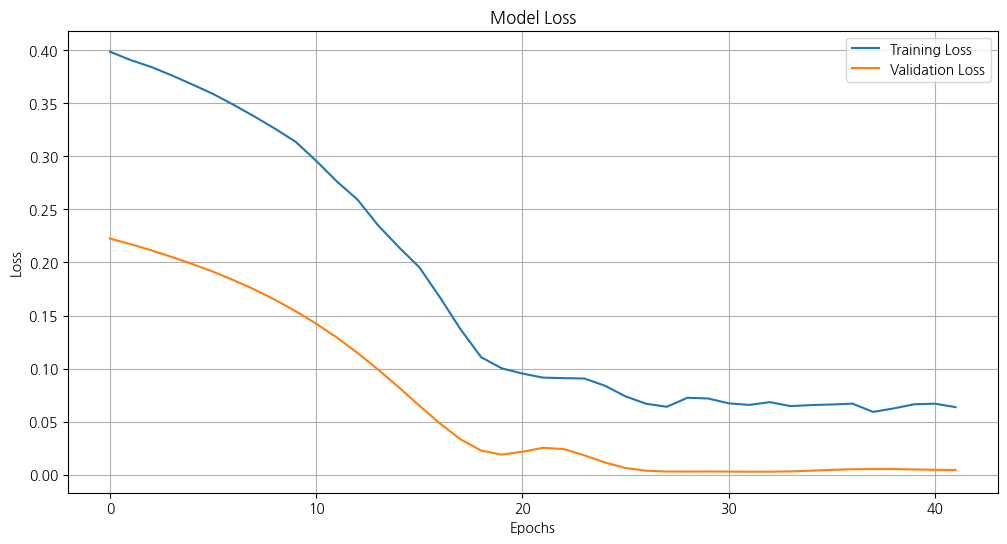

In [11]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


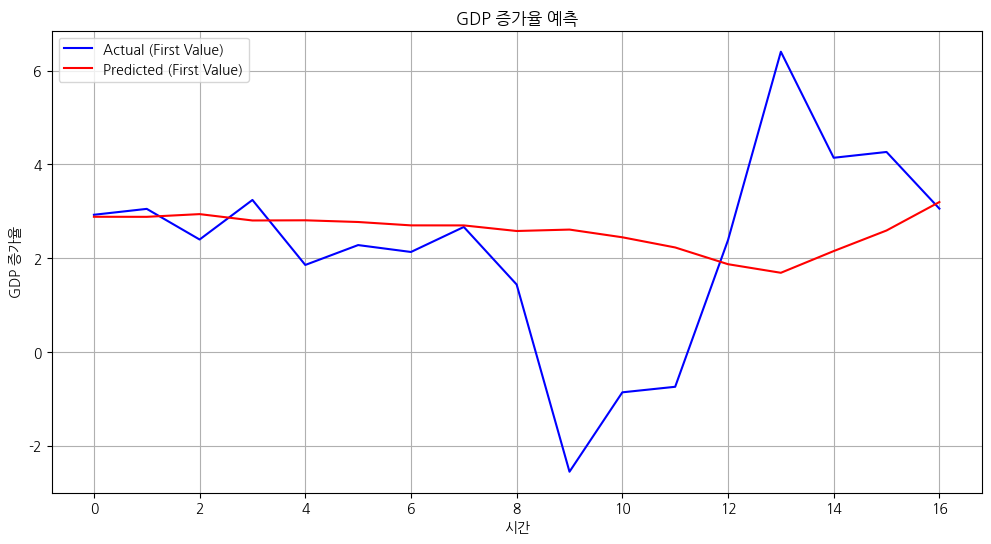

In [12]:
# 예측
y_pred_scaled = model.predict(X_test_scaled)

# 예측 결과를 원래 스케일로 변환
y_pred = inverse_transform_predictions(y_pred_scaled, y_scaler)
y_test_original = inverse_transform_predictions(y_test_scaled, y_scaler)

# 테스트 세트에 대한 예측 시각화
plt.figure(figsize=(12, 6))

# 실제 값
actual_values = [y_test_original[i][0] for i in range(len(y_test_original))]
plt.plot(actual_values, label='Actual (First Value)', color='blue')

# 예측 값
predicted_values = [y_pred[i][0] for i in range(len(y_pred))]
plt.plot(predicted_values, label='Predicted (First Value)', color='red')

plt.title('GDP 증가율 예측')
plt.ylabel('GDP 증가율')
plt.xlabel('시간')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# 평가 지표 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모든 테스트 샘플과 모든 예측 시점에 대한 오차 계산
mse = mean_squared_error(y_test_original.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original.flatten(), y_pred.flatten())

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 4.9913
RMSE: 2.2341
MAE: 1.6664


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


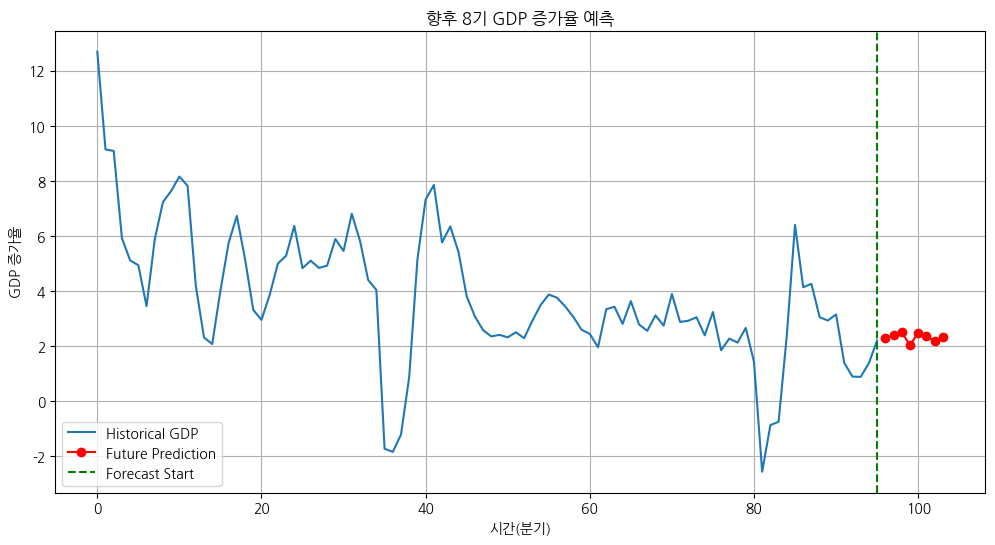

In [14]:
# 향후 8 시점 예측
# 가장 최근 데이터에서 마지막 input_seq_len개 포인트를 가져와 예측
latest_data = Gr_gdp[-input_seq_len:].reshape(1, input_seq_len, 1)
latest_data_scaled = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, input_seq_len, 1)

future_pred_scaled = model.predict(latest_data_scaled)
future_pred = y_scaler.inverse_transform(future_pred_scaled).reshape(-1)

# 향후 예측 시각화
plt.figure(figsize=(12, 6))

# 과거 데이터
plt.plot(range(len(Gr_gdp)), Gr_gdp, label='Historical GDP')

# 향후 예측
future_index = range(len(Gr_gdp), len(Gr_gdp) + output_seq_len)
plt.plot(future_index, future_pred, label='Future Prediction', color='red', marker='o')

plt.axvline(x=len(Gr_gdp)-1, color='green', linestyle='--', label='Forecast Start')
plt.title('향후 8기 GDP 증가율 예측')
plt.ylabel('GDP 증가율')
plt.xlabel('시간(분기)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print("향후 8 시점 GDP 증가율 예측치:")
for i, pred in enumerate(future_pred):
    print(f"시점 {i+1}: {pred:.4f}")

향후 8 시점 GDP 증가율 예측치:
시점 1: 2.2963
시점 2: 2.4084
시점 3: 2.5210
시점 4: 2.0325
시점 5: 2.4903
시점 6: 2.3798
시점 7: 2.1776
시점 8: 2.3407


### 2) Bidirectional LSTM 모형 구축

In [16]:
# Bidirectional LSTM 모형 구축
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(input_seq_len, 1)))
model.add(Dense(output_seq_len))  # 출력은 다음 4 시점

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')
model.summary()

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
                    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,608 (84.41 KB)

 Trainable params: 21,608 (84.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - loss: 0.4078 - val_loss: 0.2222
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3963 - val_loss: 0.2146
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3852 - val_loss: 0.2070
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3740 - val_loss: 0.1992
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3627 - val_loss: 0.1914
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3512 - val_loss: 0.1834
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3393 - val_loss: 0.1752
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3272 - val_loss: 0.1667
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3145 - val_loss: 0.1578
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3014 - val_loss: 0.1485
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2875 - val_loss: 0.1386
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2729 - val_l

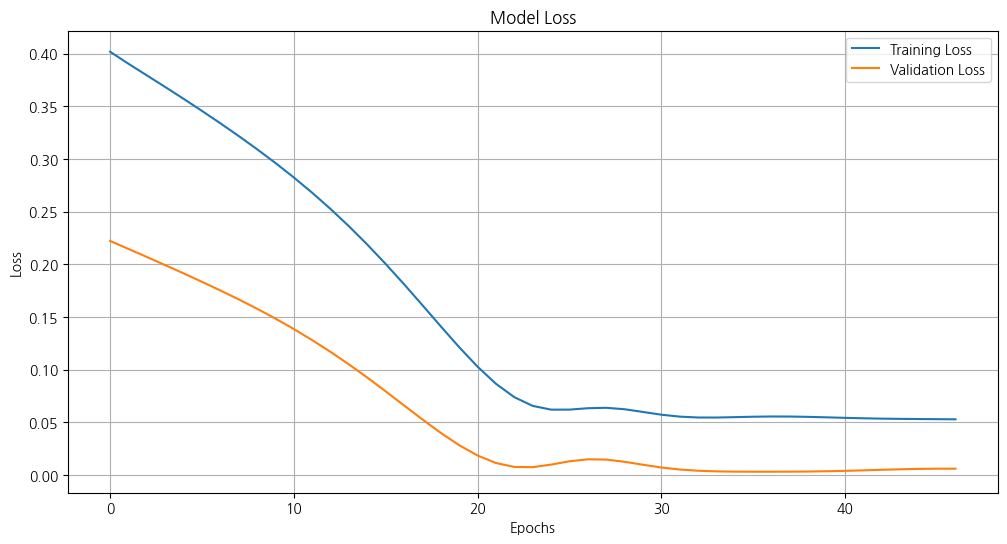

In [18]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


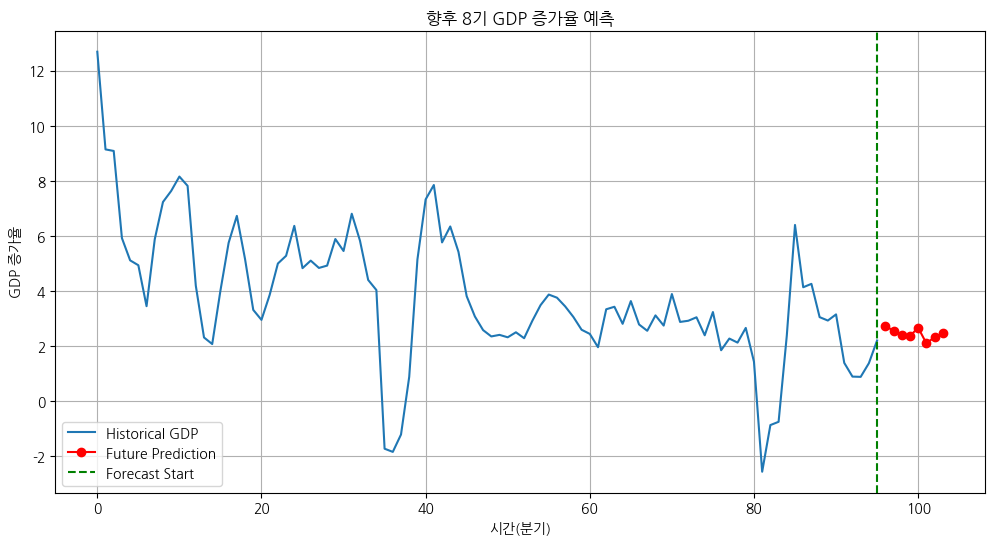

In [19]:
# 향후 8 시점 예측
# 가장 최근 데이터에서 마지막 input_seq_len개 포인트를 가져와 예측
latest_data = Gr_gdp[-input_seq_len:].reshape(1, input_seq_len, 1)
latest_data_scaled = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, input_seq_len, 1)

future_pred_scaled = model.predict(latest_data_scaled)
future_pred = y_scaler.inverse_transform(future_pred_scaled).reshape(-1)

# 향후 예측 시각화
plt.figure(figsize=(12, 6))

# 과거 데이터
plt.plot(range(len(Gr_gdp)), Gr_gdp, label='Historical GDP')

# 향후 예측
future_index = range(len(Gr_gdp), len(Gr_gdp) + output_seq_len)
plt.plot(future_index, future_pred, label='Future Prediction', color='red', marker='o')

plt.axvline(x=len(Gr_gdp)-1, color='green', linestyle='--', label='Forecast Start')
plt.title('향후 8기 GDP 증가율 예측')
plt.ylabel('GDP 증가율')
plt.xlabel('시간(분기)')
plt.legend()
plt.grid(True)
plt.show()

### 3) CNN-LSTM

,con,inv,gov,ex,im,gdp,cpi,m2,r,un,rgdp
4,159203,66238,30448,49224,57659,210586,62.7,684735,9.1,5.5,12.692985
5,152124,79046,27379,54719,57013,225288,62.6,683705,8.9,4.2,9.146932
6,154595,81193,28034,56508,58466,230172,63.4,697736,7.9,4.0,9.090392
7,161808,79293,29874,58507,58667,237505,63.9,707699,7.3,4.0,5.926874
8,164122,65215,31655,53464,56794,221365,65.0,720213,5.8,5.2,5.118574
...,...,...,...,...,...,...,...,...,...,...,...
95,325942,159480,89949,222599,194752,513770,109.2,3758236,3.9,2.6,1.396504
96,328884,132943,94701,212895,198370,472156,110.3,3776930,3.5,3.2,0.898598
97,318658,146190,89061,217836,185450,497346,111.0,3808194,3.4,2.7,0.889113
98,316042,148498,82450,229953,192882,500997,112.1,3839469,3.7,2.3,1.384586


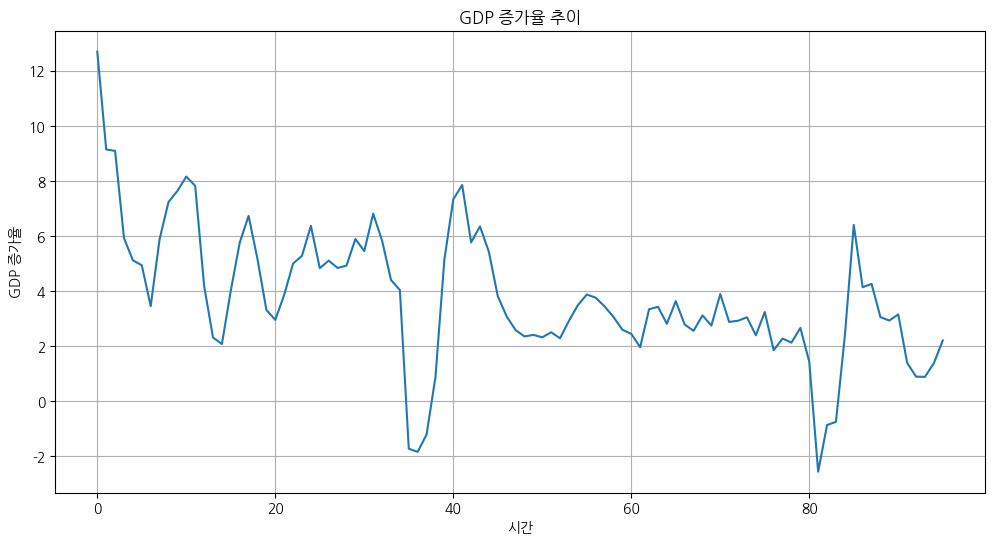

X shape: (85, 4, 1), y shape: (85, 8, 1)


In [20]:
# 작업공간(working directory) 지정
import os  
os.chdir("E:/JupyterWDirectory/MyStock")

# 현재 작업공간(working directory) 확인
os.getcwd() 

import warnings
warnings.filterwarnings("ignore")

# 한국 GDP증가율 예측을 위한 CNN-LSTM 모형 구축
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

import sys
sys.path.append('Functions')
from TS_Generator import create_sequence_data, split_train_test, scale_data, inverse_transform_predictions

# 랜덤시드 reproducibility
tf.random.set_seed(12345)

# 데이터세트 불러오기(1999Q1-2023Q4)
# 한국의 거시통계(소비, 투자, 정부지출, 수출, 수입, GDP, 소비자물가, M2, 이자율, 실업률
# (time	con	inv	gov	ex	im	gdp	cpi	m2	r	un)
dataframe = pd.read_csv('Data/Korea_macro.csv', usecols=range(1, 11))

dataframe['rgdp'] = dataframe['gdp'].pct_change(4) * 100
dataframe.dropna(inplace=True)
display(dataframe)

# GDP 증가율
Gr_gdp = dataframe['rgdp'].values

# GDP 증가율 그래프
plt.figure(figsize=(12, 6))
plt.plot(Gr_gdp)
plt.title('GDP 증가율 추이')
plt.ylabel('GDP 증가율')
plt.xlabel('시간')
plt.grid(True)
plt.show()

# 입력 및 출력 시퀀스 길이 설정
input_seq_len = 4  # 시차 8
output_seq_len = 8  # 다음 8 예측

# 시퀀스 데이터 생성
X, y = create_sequence_data(Gr_gdp, input_seq_len=input_seq_len, output_seq_len=output_seq_len)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# 훈련/테스트 데이터 분할 (시간 순서 유지)
X_train, X_test, y_train, y_test = split_train_test(X, y, test_ratio=0.2, shuffle=False)

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale_data(X_train, X_test, y_train, y_test, scaler=scaler)

In [21]:
# CNN-LSTM 모델 구축
model = Sequential()

# 1D CNN 레이어 추가 - padding='same'으로 변경하여 출력 크기 유지
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(input_seq_len, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# 두 번째 CNN 레이어 - 작은 커널 사이즈와 padding='same' 사용
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', padding='same'))

# MaxPooling 제거하여 더 이상의 시퀀스 길이 감소 방지
model.add(Dropout(0.2))

# LSTM 레이어 추가
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

# 출력 레이어
model.add(Dense(output_seq_len))

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2, 32)               │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 2, 50)               │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,480 (154.22 KB)

 Trainable params: 39,480 (154.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - loss: 0.4096 - val_loss: 0.2273
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.4048 - val_loss: 0.2234
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3995 - val_loss: 0.2194
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3943 - val_loss: 0.2149
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3888 - val_loss: 0.2101
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3822 - val_loss: 0.2046
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3735 - val_loss: 0.1984
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3658 - val_loss: 0.1913
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3550 - val_loss: 0.1833
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3439 - val_loss: 0.1739
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3303 - val_loss: 0.1631
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3146 - val_l

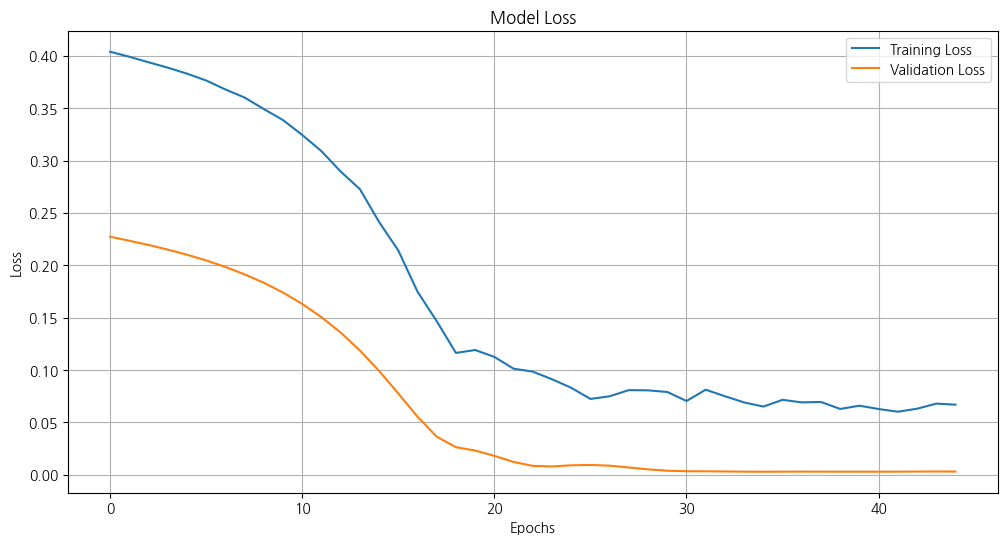

In [22]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 훈련 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


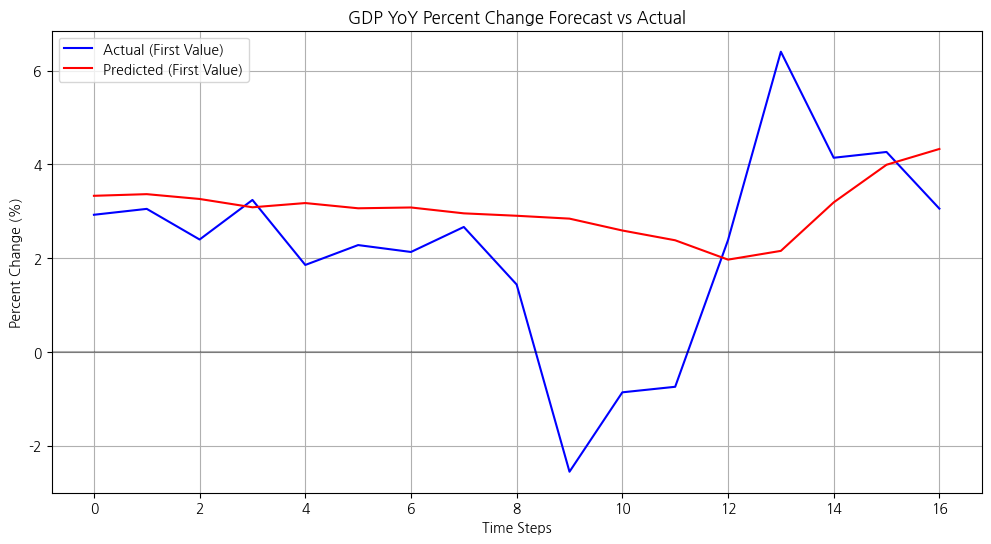

MSE: 5.2367
RMSE: 2.2884
MAE: 1.7395


In [23]:
# 예측
y_pred_scaled = model.predict(X_test_scaled)

# 예측 결과를 원래 스케일로 변환
y_pred = inverse_transform_predictions(y_pred_scaled, y_scaler)
y_test_original = inverse_transform_predictions(y_test_scaled, y_scaler)

# 테스트 세트에 대한 예측 시각화
plt.figure(figsize=(12, 6))

# 실제 값들 - 첫 번째 값들만 추출하여 플랏
actual_values = [y_test_original[i][0] for i in range(len(y_test_original))]
plt.plot(actual_values, label='Actual (First Value)', color='blue')

# 예측 값들 - 첫 번째 값들만 추출하여 플랏
predicted_values = [y_pred[i][0] for i in range(len(y_pred))]
plt.plot(predicted_values, label='Predicted (First Value)', color='red')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('GDP YoY Percent Change Forecast vs Actual')
plt.ylabel('Percent Change (%)')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)
plt.show()

# 평가 지표 계산
# 모든 테스트 샘플과 모든 예측 시점에 대한 오차 계산
mse = mean_squared_error(y_test_original.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original.flatten(), y_pred.flatten())

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


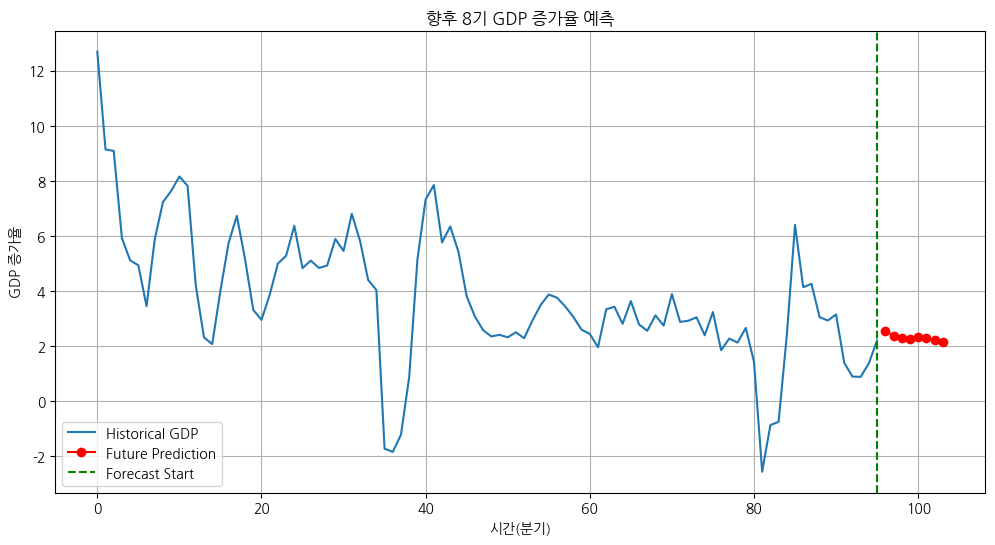

In [24]:
# 향후 8 시점 예측
# 가장 최근 데이터에서 마지막 input_seq_len개 포인트를 가져와 예측
latest_data = Gr_gdp[-input_seq_len:].reshape(1, input_seq_len, 1)
latest_data_scaled = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, input_seq_len, 1)

future_pred_scaled = model.predict(latest_data_scaled)
future_pred = y_scaler.inverse_transform(future_pred_scaled).reshape(-1)

# 향후 예측 시각화
plt.figure(figsize=(12, 6))

# 과거 데이터
plt.plot(range(len(Gr_gdp)), Gr_gdp, label='Historical GDP')

# 향후 예측
future_index = range(len(Gr_gdp), len(Gr_gdp) + output_seq_len)
plt.plot(future_index, future_pred, label='Future Prediction', color='red', marker='o')

plt.axvline(x=len(Gr_gdp)-1, color='green', linestyle='--', label='Forecast Start')
plt.title('향후 8기 GDP 증가율 예측')
plt.ylabel('GDP 증가율')
plt.xlabel('시간(분기)')
plt.legend()
plt.grid(True)
plt.show()

### 4) ConvLSTM

In [25]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization

# ConvLSTM을 위한 입력 형태 변환
# ConvLSTM은 5D 텐서를 입력으로 받음: [samples, time_steps, rows, cols, channels]
# 여기서는 rows=1, cols=1, channels=1로 설정
X_train_convlstm = X_train_scaled.reshape(X_train_scaled.shape[0], input_seq_len, 1, 1, 1)
X_test_convlstm = X_test_scaled.reshape(X_test_scaled.shape[0], input_seq_len, 1, 1, 1)

# ConvLSTM 모델 구축
model = Sequential()

# ConvLSTM 레이어 추가
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), 
                     activation='relu', 
                     input_shape=(input_seq_len, 1, 1, 1),
                     return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), 
                     activation='relu',
                     return_sequences=False))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_seq_len))

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 4, 1, 1, 64)         │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 1, 1, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 1, 1, 32)            │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 1, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           1,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,754 (124.04 KB)

 Trainable params: 31,562 (123.29 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 696ms/step - loss: 1.0076 - val_loss: 0.2256
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7158 - val_loss: 0.2203
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.6035 - val_loss: 0.2148
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.5100 - val_loss: 0.2094
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4575 - val_loss: 0.2040
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4180 - val_loss: 0.1990
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.3552 - val_loss: 0.1944
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.3265 - val_loss: 0.1900
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2744 - val_loss: 0.1858
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2393 - val_loss: 0.1818
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2529 - val_loss: 0.1779
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2331 - val_l

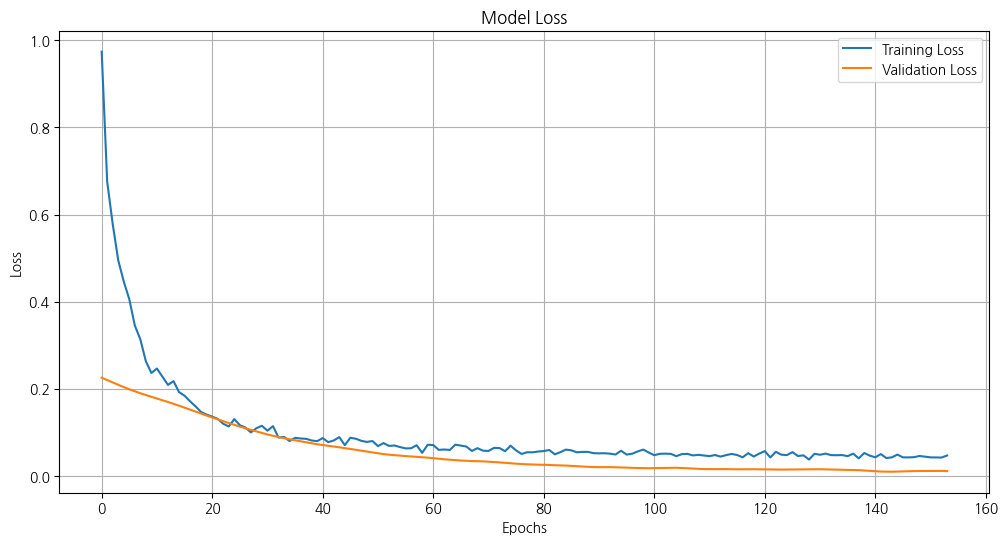

In [26]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_convlstm, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 훈련 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


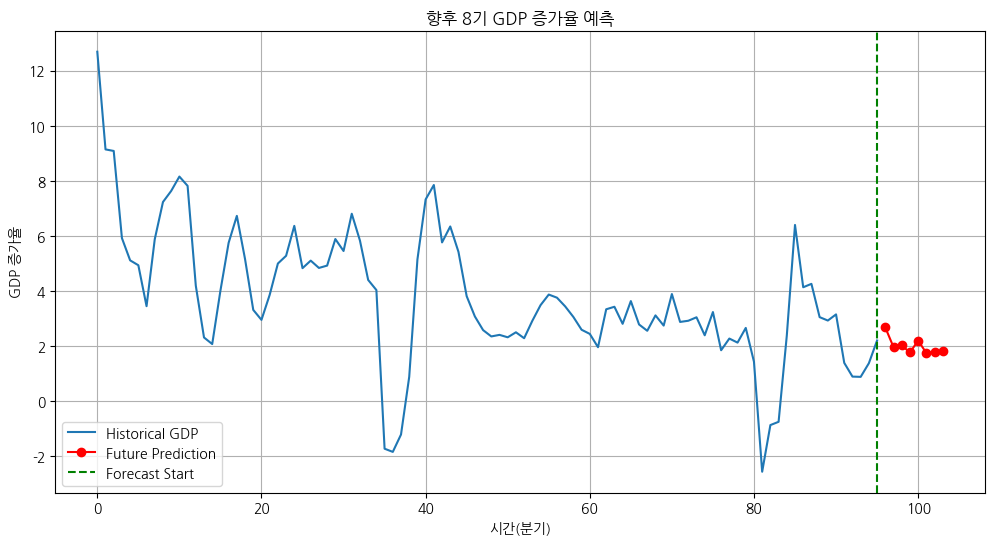

In [28]:
# 향후 8 시점 예측
# 가장 최근 데이터에서 마지막 input_seq_len개 포인트를 가져와 예측
latest_data = Gr_gdp[-input_seq_len:].reshape(1, input_seq_len, 1)
latest_data_scaled = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, input_seq_len, 1)

# ConvLSTM은 5차원 입력이 필요: (samples, time_steps, rows, cols, features)
latest_data_scaled_conv = latest_data_scaled.reshape(1, input_seq_len, 1, 1, 1)
future_pred_scaled = model.predict(latest_data_scaled_conv)

# 출력도 형태 변환이 필요
# 모델 출력이 5차원이라면 3차원으로 변환
if len(future_pred_scaled.shape) == 5:
    future_pred_scaled = future_pred_scaled.reshape(1, output_seq_len, 1)

future_pred = y_scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).reshape(-1)

# 향후 예측 시각화
plt.figure(figsize=(12, 6))
# 과거 데이터
plt.plot(range(len(Gr_gdp)), Gr_gdp, label='Historical GDP')
# 향후 예측
future_index = range(len(Gr_gdp), len(Gr_gdp) + output_seq_len)
plt.plot(future_index, future_pred, label='Future Prediction', color='red', marker='o')
plt.axvline(x=len(Gr_gdp)-1, color='green', linestyle='--', label='Forecast Start')
plt.title('향후 8기 GDP 증가율 예측')
plt.ylabel('GDP 증가율')
plt.xlabel('시간(분기)')
plt.legend()
plt.grid(True)
plt.show()

### 다. LSTM을 이용한 다변량 시계열 예측

       Gr_gdp     Gr_con     Gr_inv    Gr_gov
4   12.692985  11.411796  25.334443  3.437967
5    9.146932   9.793223  12.074295  0.624793
6    9.090392   6.357582  13.187794 -0.967924
7    5.926874   4.118862   9.807370 -0.416681
8    5.118574   3.089766  -1.544431  3.964136
..        ...        ...        ...       ...
95   1.396504   3.370281   1.544045  3.633850
96   0.898598   4.388398   6.390147  4.038451
97   0.889113   1.391090   2.290856  0.955587
98   1.384586   0.490941  -1.694713  1.093700
99   2.209744   0.451307  -2.684349 -0.923857

[96 rows x 4 columns]


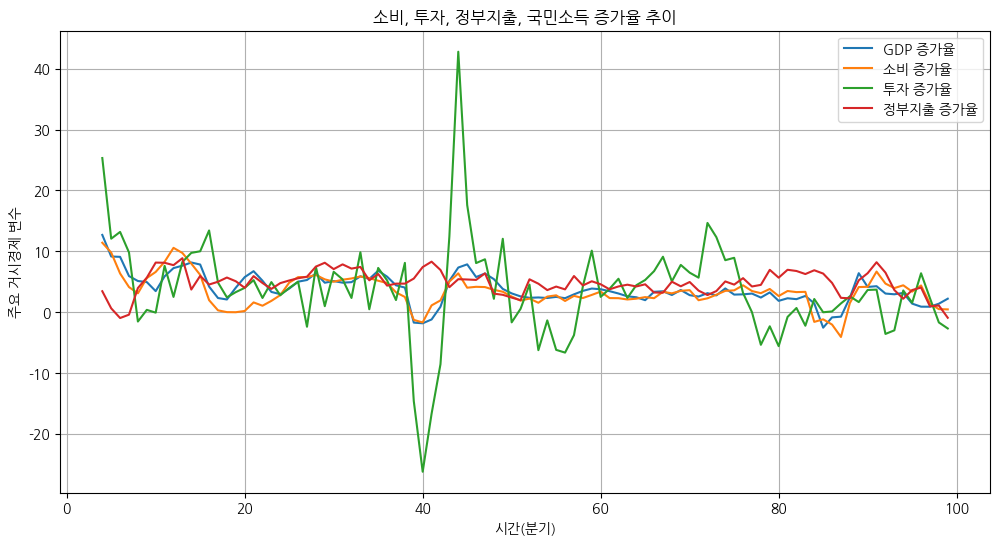

In [29]:
# 작업공간(working directory) 지정
import os  
os.chdir("E:/JupyterWDirectory/MyStock")

# 현재 작업공간(working directory) 확인
os.getcwd() 

import warnings
warnings.filterwarnings("ignore")

# 다변량 예측을 위한 LSTM 모형 구축
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.callbacks import EarlyStopping

# 한글폰트
import matplotlib as mpl
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

import sys
sys.path.append('Functions')
from TS_Generator import create_sequence_data, split_train_test, scale_data, inverse_transform_predictions

# 데이터세트 불러오기(1999Q1-2023Q4)
# 한국의 거시통계(소비, 투자, 정부지출, 수출, 수입, GDP, 소비자물가, M2, 이자율, 실업률
dataset = pd.read_csv('Data/Korea_macro.csv', usecols=range(1, 11))
dataset['Gr_gdp'] = dataset['gdp'].pct_change(4) * 100
dataset['Gr_con'] = dataset['con'].pct_change(4) * 100
dataset['Gr_inv'] = dataset['inv'].pct_change(4) * 100
dataset['Gr_gov'] = dataset['gov'].pct_change(4) * 100
dataset = dataset.filter(like='Gr_')
dataset.dropna(inplace=True)
print(dataset)

# 시각화 
plt.figure(figsize=(12, 6))
# 각 선에 레이블 추가
plt.plot(dataset['Gr_gdp'], label='GDP 증가율')
plt.plot(dataset['Gr_con'], label='소비 증가율')
plt.plot(dataset['Gr_inv'], label='투자 증가율')
plt.plot(dataset['Gr_gov'], label='정부지출 증가율')
plt.title('소비, 투자, 정부지출, 국민소득 증가율 추이')
plt.ylabel('주요 거시경제 변수')
plt.xlabel('시간(분기)')
plt.grid(True)
# 범례 추가
plt.legend(loc='best')  
plt.show()

X shape: (85, 4, 4), y shape: (85, 8, 3)
y_train_scaled shape: (68, 8, 3)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 4, 100)              │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 24)                  │           2,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 3)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,824 (487.59 KB)

 Trainable params: 124,824 (487.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - loss: 0.2758 - val_loss: 0.1962
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2676 - val_loss: 0.1897
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2594 - val_loss: 0.1823
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2503 - val_loss: 0.1739
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2397 - val_loss: 0.1640
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2272 - val_loss: 0.1521
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2123 - val_loss: 0.1378
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1943 - val_loss: 0.1207
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.1729 - val_loss: 0.1008
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1483 - val_loss: 0.0788
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1219 - val_loss: 0.0571
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0985 - val_

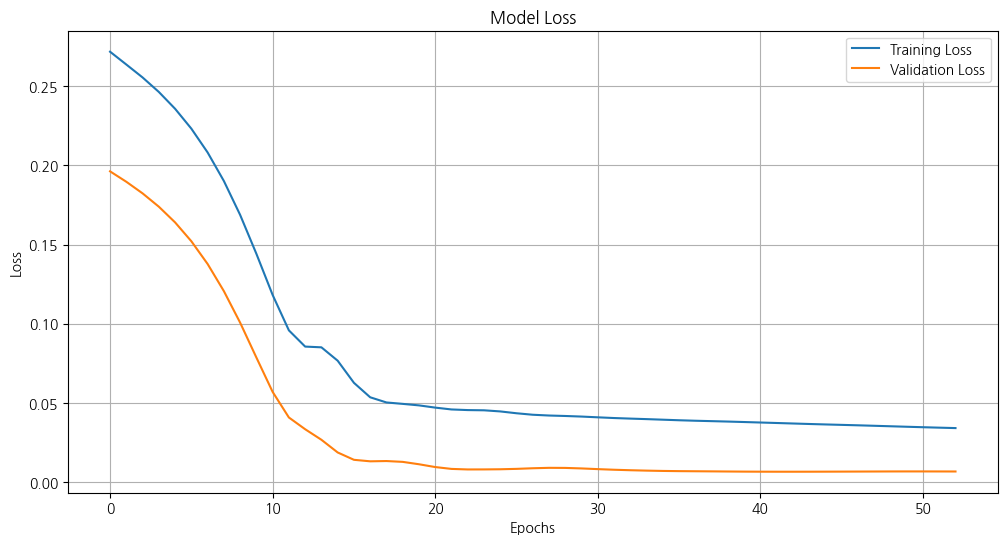

In [35]:
# 입력 및 출력 시퀀스 길이 설정
input_seq_len = 4  # 시차 4
output_seq_len = 8  # 다음 8 예측

# 시퀀스 데이터 생성
X, y = create_sequence_data(dataset, input_seq_len=input_seq_len, output_seq_len=output_seq_len, target_columns=[0, 1, 2])
print(f"X shape: {X.shape}, y shape: {y.shape}")

# 훈련/테스트 데이터 분할 (시간 순서 유지)
X_train, X_test, y_train, y_test = split_train_test(X, y, test_ratio=0.2, shuffle=False)

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale_data(X_train, X_test, y_train, y_test, scaler=scaler)

# y의 형태 확인
print(f"y_train_scaled shape: {y_train_scaled.shape}")  

# 방법 1: Dense 출력층 수정 (타겟 컬럼 수에 맞게)
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(input_seq_len, X_train_scaled.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(output_seq_len * 3))  
model.add(tf.keras.layers.Reshape((output_seq_len, 3)))  

# 모형 컴파일
model.compile(optimizer='adam', loss='mse')
model.summary()

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 훈련 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


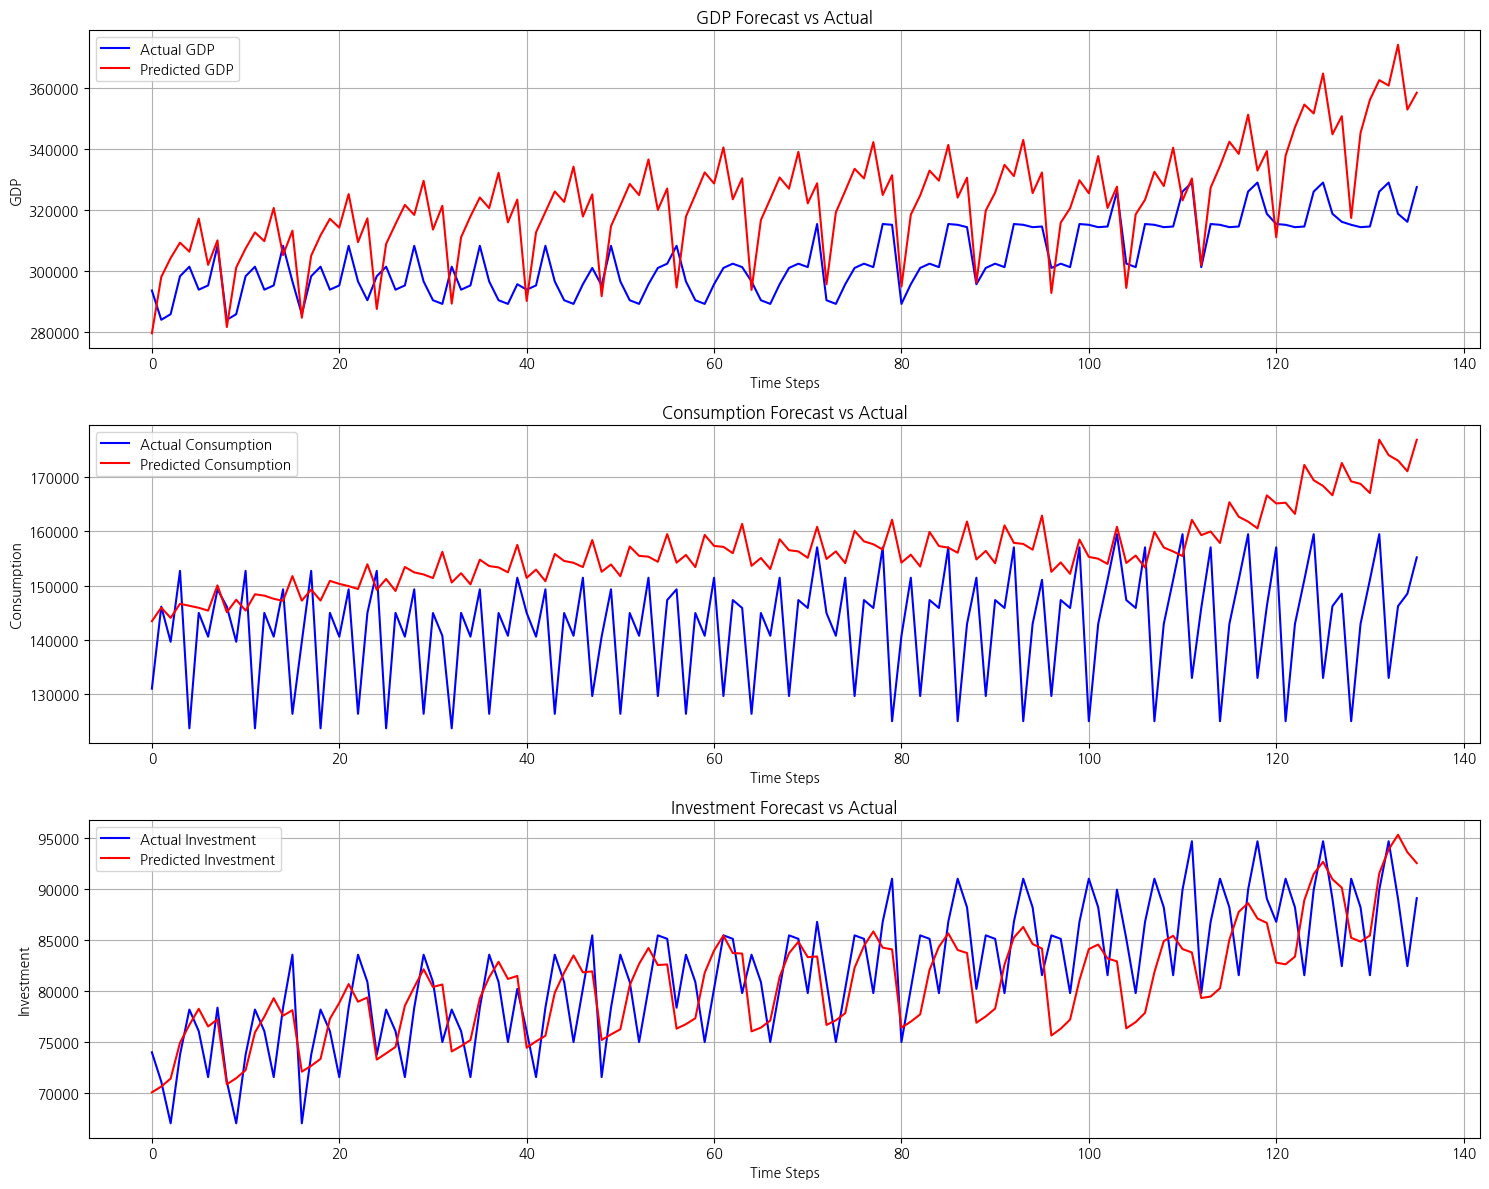


GDP 평가 지표:
MSE: 556247747.9123
RMSE: 23584.9051
MAE: 20471.4366

Consumption 평가 지표:
MSE: 311207293.6512
RMSE: 17641.0684
MAE: 14128.7611

Investment 평가 지표:
MSE: 22333538.3248
RMSE: 4725.8373
MAE: 3921.1117


In [31]:
# 예측
y_pred_scaled = model.predict(X_test_scaled)

# 예측 결과를 원래 스케일로 변환
y_pred = inverse_transform_predictions(y_pred_scaled, y_scaler)
y_test_original = inverse_transform_predictions(y_test_scaled, y_scaler)

# 각 변수별로 시각화 (GDP, 소비, 투자)
variable_names = ['GDP', 'Consumption', 'Investment']

# 모든 테스트 샘플에 대한 예측 시각화 (각 변수별로)
plt.figure(figsize=(15, 12))

for var_idx in range(3):  # 3개 변수 (소비, 투자, GDP)
    plt.subplot(3, 1, var_idx+1)
    # 실제값
    actual_values = []
    for i in range(len(y_test_original)):
        actual_values.extend(y_test_original[i, :, var_idx])
    plt.plot(actual_values, label=f'Actual {variable_names[var_idx]}', color='blue')
    # 예측값
    predicted_values = []
    for i in range(len(y_pred)):
        predicted_values.extend(y_pred[i, :, var_idx])
    plt.plot(predicted_values, label=f'Predicted {variable_names[var_idx]}', color='red')
    
    plt.title(f'{variable_names[var_idx]} Forecast vs Actual')
    plt.ylabel(variable_names[var_idx])
    plt.xlabel('Time Steps')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# 평가 지표 계산 (각 변수별로)
from sklearn.metrics import mean_squared_error, mean_absolute_error

for var_idx in range(3):
    # 특정 변수에 대한 실제값과 예측값 추출
    y_true = y_test_original[:, :, var_idx].flatten()
    y_predicted = y_pred[:, :, var_idx].flatten()
    
    # 평가 지표 계산
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_predicted)
    
    print(f"\n{variable_names[var_idx]} 평가 지표:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


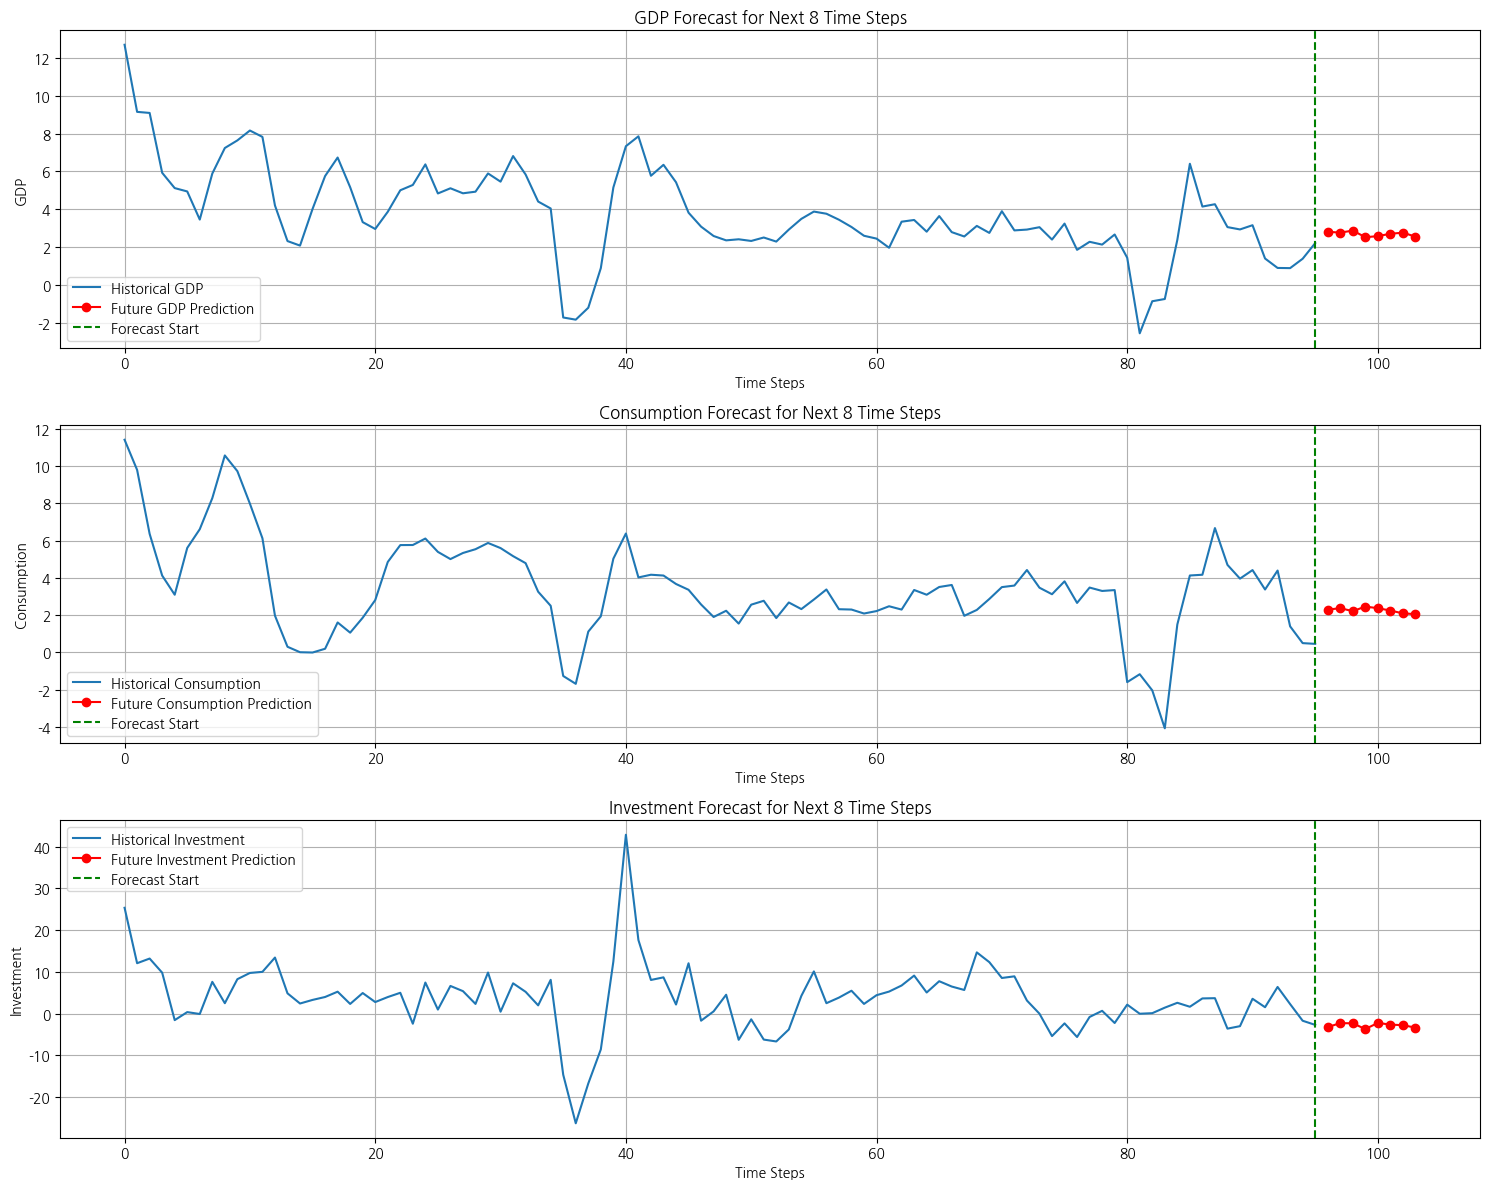

In [36]:
# 향후 예측을 위해 최신 데이터 준비
# 원본 데이터에서 최근 input_seq_len 개의 데이터 포인트 가져오기
latest_data = dataset[-input_seq_len:].values.reshape(1, input_seq_len, 4)

# 데이터 스케일링
latest_data_scaled = scaler.transform(latest_data.reshape(-1, 4)).reshape(1, input_seq_len, 4)

# 향후 output_seq_len 시점 예측
future_pred_scaled = model.predict(latest_data_scaled)
future_pred = inverse_transform_predictions(future_pred_scaled, y_scaler)

# 향후 예측 시각화 (각 변수별로)
plt.figure(figsize=(15, 12))

# 변수 열 이름 목록
column_names = dataset.columns[[0, 1, 2]]  # 첫 3개 열의 이름

for var_idx in range(3):
    plt.subplot(3, 1, var_idx+1)
    # 과거 데이터 (해당 변수만)
    column_name = column_names[var_idx]
    historical_data = dataset[column_name]
    plt.plot(range(len(historical_data)), historical_data, label=f'Historical {variable_names[var_idx]}')
    # 향후 예측
    future_index = range(len(historical_data), len(historical_data) + output_seq_len)
    plt.plot(future_index, future_pred[0, :, var_idx], label=f'Future {variable_names[var_idx]} Prediction', 
             color='red', marker='o')
    plt.axvline(x=len(historical_data)-1, color='green', linestyle='--', label='Forecast Start')
    plt.title(f'{variable_names[var_idx]} Forecast for Next 8 Time Steps')
    plt.ylabel(variable_names[var_idx])
    plt.xlabel('Time Steps')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# 향후 8 시점 예측값 출력 (각 변수별로)
for var_idx in range(3):
    print(f"\n향후 8 시점 {variable_names[var_idx]} 예측값:")
    for i in range(output_seq_len):
        print(f"시점 {i+1}: {future_pred[0, i, var_idx]:.4f}")


향후 8 시점 GDP 예측값:
시점 1: 2.8109
시점 2: 2.7660
시점 3: 2.8722
시점 4: 2.5244
시점 5: 2.5780
시점 6: 2.7069
시점 7: 2.7614
시점 8: 2.5547

향후 8 시점 Consumption 예측값:
시점 1: 2.2891
시점 2: 2.3671
시점 3: 2.2080
시점 4: 2.4527
시점 5: 2.3674
시점 6: 2.2400
시점 7: 2.0888
시점 8: 2.0487

향후 8 시점 Investment 예측값:
시점 1: -3.2153
시점 2: -2.2616
시점 3: -2.3120
시점 4: -3.6772
시점 5: -2.2145
시점 6: -2.6205
시점 7: -2.7546
시점 8: -3.3439


### 3. GRU를 이용한 시계열 예측

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping

# GRU 기반 모형 정의
model = Sequential()
model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(input_seq_len, X_train_scaled.shape[2])))
model.add(GRU(100, activation='relu'))
model.add(Dense(output_seq_len * 3))  # 예측할 타깃 수 (3개 변수 × 8시점)
model.add(Reshape((output_seq_len, 3)))

# 컴파일 및 학습 설정
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - loss: 0.2703 - val_loss: 0.1856
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2525 - val_loss: 0.1696
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2328 - val_loss: 0.1513
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2108 - val_loss: 0.1308
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1864 - val_loss: 0.1076
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1588 - val_loss: 0.0818
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1291 - val_loss: 0.0558
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1009 - val_loss: 0.0350
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0810 - val_loss: 0.0249
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0738 - val_loss: 0.0220
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0703 - val_loss: 0.0171
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0608 - val_l

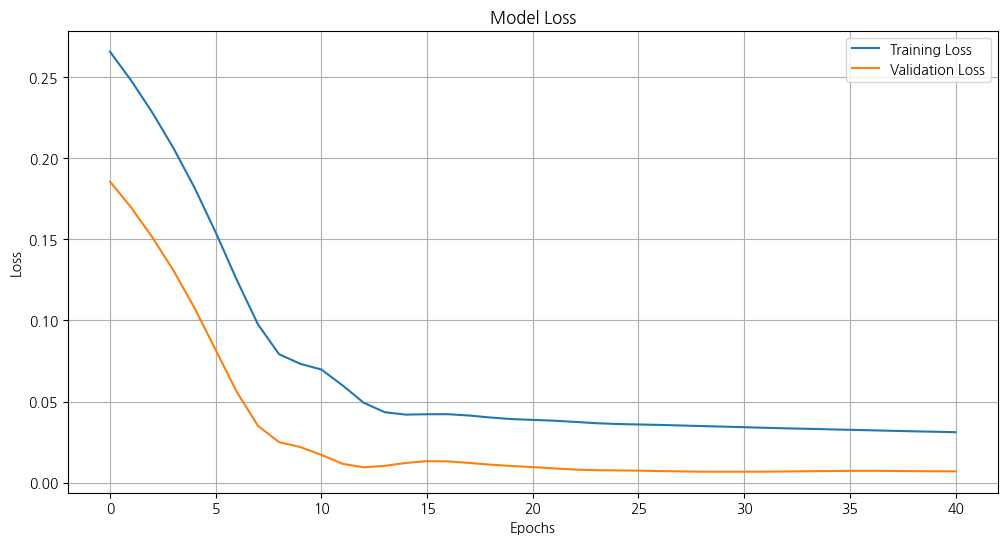

In [39]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


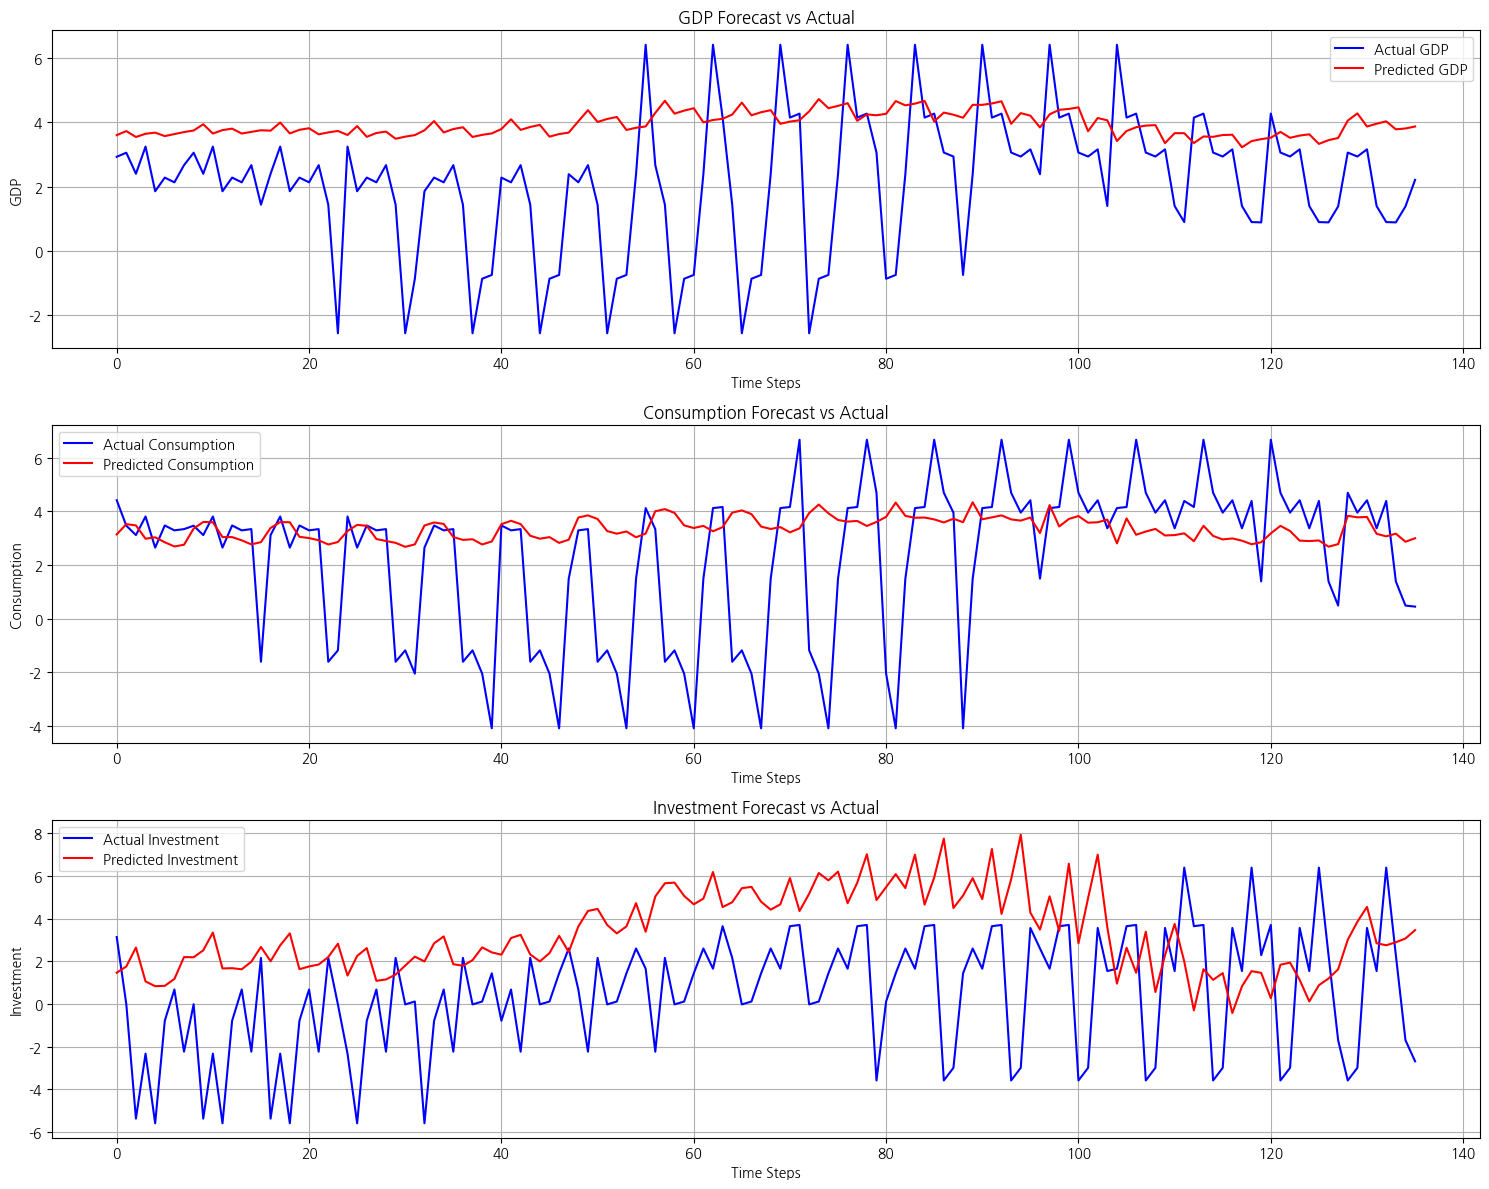


GDP 평가 지표:
MSE: 7.5959
RMSE: 2.7561
MAE: 2.1398

Consumption 평가 지표:
MSE: 9.1149
RMSE: 3.0191
MAE: 2.0933

Investment 평가 지표:
MSE: 18.2099
RMSE: 4.2673
MAE: 3.5468


In [40]:
# 예측
y_pred_scaled = model.predict(X_test_scaled)

# 예측 결과를 원래 스케일로 변환
y_pred = inverse_transform_predictions(y_pred_scaled, y_scaler)
y_test_original = inverse_transform_predictions(y_test_scaled, y_scaler)

# 각 변수별로 시각화 (GDP, 소비, 투자)
variable_names = ['GDP', 'Consumption', 'Investment']

# 모든 테스트 샘플에 대한 예측 시각화 (각 변수별로)
plt.figure(figsize=(15, 12))

for var_idx in range(3):  # 3개 변수 (소비, 투자, GDP)
    plt.subplot(3, 1, var_idx+1)
    # 실제값
    actual_values = []
    for i in range(len(y_test_original)):
        actual_values.extend(y_test_original[i, :, var_idx])
    plt.plot(actual_values, label=f'Actual {variable_names[var_idx]}', color='blue')
    # 예측값
    predicted_values = []
    for i in range(len(y_pred)):
        predicted_values.extend(y_pred[i, :, var_idx])
    plt.plot(predicted_values, label=f'Predicted {variable_names[var_idx]}', color='red')
    
    plt.title(f'{variable_names[var_idx]} Forecast vs Actual')
    plt.ylabel(variable_names[var_idx])
    plt.xlabel('Time Steps')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# 평가 지표 계산 (각 변수별로)
from sklearn.metrics import mean_squared_error, mean_absolute_error

for var_idx in range(3):
    # 특정 변수에 대한 실제값과 예측값 추출
    y_true = y_test_original[:, :, var_idx].flatten()
    y_predicted = y_pred[:, :, var_idx].flatten()
    
    # 평가 지표 계산
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_predicted)
    
    print(f"\n{variable_names[var_idx]} 평가 지표:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


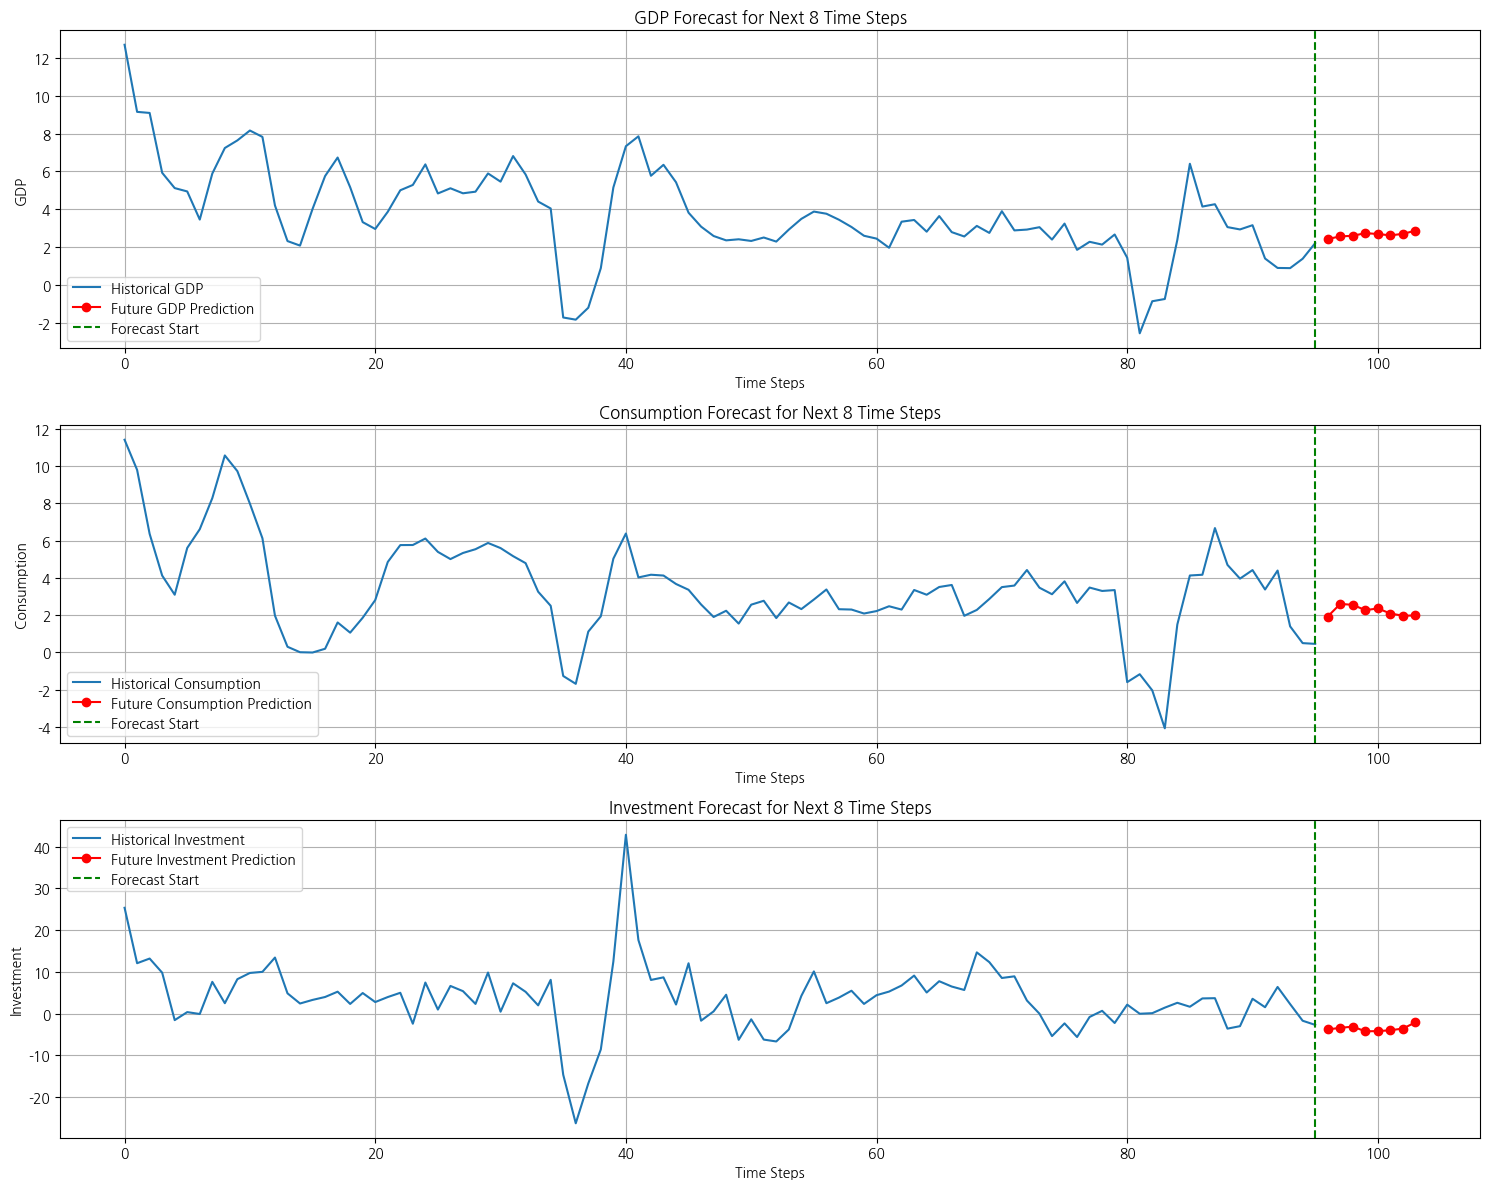

In [41]:
# 향후 예측을 위해 최신 데이터 준비
# 원본 데이터에서 최근 input_seq_len 개의 데이터 포인트 가져오기
latest_data = dataset[-input_seq_len:].values.reshape(1, input_seq_len, 4)

# 데이터 스케일링
latest_data_scaled = scaler.transform(latest_data.reshape(-1, 4)).reshape(1, input_seq_len, 4)

# 향후 output_seq_len 시점 예측
future_pred_scaled = model.predict(latest_data_scaled)
future_pred = inverse_transform_predictions(future_pred_scaled, y_scaler)

# 향후 예측 시각화 (각 변수별로)
plt.figure(figsize=(15, 12))

# 변수 열 이름 목록
column_names = dataset.columns[[0, 1, 2]]  # 첫 3개 열의 이름

for var_idx in range(3):
    plt.subplot(3, 1, var_idx+1)
    # 과거 데이터 (해당 변수만)
    column_name = column_names[var_idx]
    historical_data = dataset[column_name]
    plt.plot(range(len(historical_data)), historical_data, label=f'Historical {variable_names[var_idx]}')
    # 향후 예측
    future_index = range(len(historical_data), len(historical_data) + output_seq_len)
    plt.plot(future_index, future_pred[0, :, var_idx], label=f'Future {variable_names[var_idx]} Prediction', 
             color='red', marker='o')
    plt.axvline(x=len(historical_data)-1, color='green', linestyle='--', label='Forecast Start')
    plt.title(f'{variable_names[var_idx]} Forecast for Next 8 Time Steps')
    plt.ylabel(variable_names[var_idx])
    plt.xlabel('Time Steps')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()